## Head Pose Estimation

### Our Problem is that we are going to estimate the head pose from some key points on our face 

### what is the pose estimation ?
- #### the pose of an object refers to its relative orientation and position with respect to a camera. You can change the pose by either moving the object with respect to the camera, or the camera with respect to the object.
- #### The pose estimation problem described in this tutorial is often referred to as Perspective-n-Point problem or PNP in computer vision jargon. As we shall see in the following sections in more detail, in this problem the goal is to find the pose of an object when we have a calibrated camera, and we know the locations of n 3D points on the object and the corresponding 2D projections in the image.

### How to mathematically represent camera motion ?
- ### 3D Object has only two kinds of motions
##### 1-Translation: Moving the camera from its current 3D location (X, Y, Z) to new 3D Location (X', Y', Z') ==> Eqn.: ( X' - X, Y' - Y, Z' - Z )
##### 2- Rotation: You can also rotate camera about X, Y and Z axes

##### You can represent it using Euler angles ( roll, pitch and yaw ), 
##### a 3 * 3 rotation matrix, or a direction of rotation (i.e. axis ) and angle.

### What do we need for pose estimation?
##### 1- 2D coordinates of a few points : (x,y) locations for a few points in the image 
##### 2- 3D coordinates of same points: reference but we really don't implement 3D Model
##### 3- Intrinsic parameters of the camera: you need to know the focal length of the camera, the optical center in the image and the radial distortion parameters

### Our Steps ?
##### 1- Read Dataset using Mediapipe from jpg files
##### 2- Read 3 Euler Angles from Mat File in Dataset 
##### 3- Refine and Prepare Data
##### 4- Preprocess Data (Normalize)
##### 5- Split Our Data
##### 6- Train Our Model
##### 7- Test and Evaluate
##### 8- Real Time Testing
##### 9- Recording Videos
##### 10- Frames Gathering

## Required Packages

In [1]:
%pip install mediapipe
%pip install mat4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import math
import glob
import random


import numpy as np
import scipy as sc
import pandas as pd
import scipy.io as sio
from math import sin, cos
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter

import cv2
import dlib
import mediapipe as mp
from pathlib import Path
from mat4py import loadmat
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

## Read Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if os.path.isdir('/content/drive/MyDrive/AFLW2000') == True:
  print("Directory Found......")

Directory Found......


## Data Preparation

In [5]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

## Explore Data

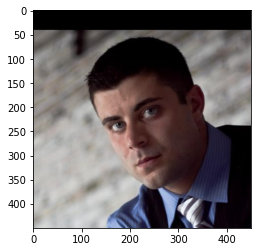

In [6]:
img = cv2.imread('/content/drive/MyDrive/AFLW2000/image00020.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [7]:
mat = sio.loadmat('/content/drive/MyDrive/AFLW2000/image00020.mat')
mat

{'Color_Para': array([[ 0.86136895,  0.98264223,  1.0366267 , -0.21083492, -0.15933153,
         -0.07723749,  1.        ]], dtype=float32),
 'Exp_Para': array([[ 1.10127702],
        [-1.64343231],
        [ 0.54430755],
        [-0.21073776],
        [-0.1626996 ],
        [-0.05028568],
        [ 0.3485597 ],
        [ 0.42446602],
        [-0.30641749],
        [ 0.44756579],
        [-0.13627036],
        [ 0.39788496],
        [-0.19177085],
        [ 0.25216886],
        [-0.31009008],
        [-0.25418855],
        [-0.20607895],
        [ 0.24985986],
        [ 0.25424617],
        [-0.06025629],
        [ 0.11241749],
        [ 0.00604992],
        [-0.15461647],
        [-0.04437201],
        [-0.0278781 ],
        [ 0.07347806],
        [-0.03126843],
        [-0.22215631],
        [-0.2192145 ]]),
 'Illum_Para': array([[ 0.73707378,  0.57378578,  0.48792496,  0.79355657,  0.95550013,
          1.01849163, -0.08837856, -1.65764105,  0.05844256, 20.        ]]),
 'Pose_Para':

## MediaPipe Config and Loading

In [8]:
faceModule = mp.solutions.face_mesh
drawing = mp.solutions.drawing_utils 
drawing_styles = mp.solutions.drawing_styles
drawing_spec = drawing.DrawingSpec(thickness=1, circle_radius=1)


## Create Records

In [9]:
def extract_data(image, mat=None):
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    data=[]
    if results.multi_face_landmarks != None: 
            
            for face in results.multi_face_landmarks:
                record = {}

                for i, landmark in enumerate(face.landmark):
                    record['x_' + str(i+1)] = landmark.x
                    record['y_' + str(i+1)] = landmark.y

                if mat:
                    pose_para = mat["Pose_Para"][0][:3]
                    record['pitch'] = pose_para[0]
                    record['yaw'] = pose_para[1]
                    record['roll'] = pose_para[2]

                data.append(record)
    return data

In [10]:
def getTrainData(filePath):
  data = []
  
  for filename in glob.glob(filePath + '/*.jpg'):
    image = cv2.imread(filename)
    mat_file = sio.loadmat(filename.replace('.jpg', '.mat'))
    data.extend(extract_data(image, mat_file))
  return data

## Get Train Data

In [11]:
path = '/content/drive/MyDrive/AFLW2000'
train_data = getTrainData(path)
train_data = pd.DataFrame(train_data)
train_data.head(5)

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,y_465,x_466,y_466,x_467,y_467,x_468,y_468,pitch,yaw,roll
0,0.533036,0.640151,0.573533,0.603662,0.540158,0.614039,0.555574,0.552323,0.578726,0.589018,...,0.510539,0.549173,0.515102,0.575083,0.503101,0.578031,0.498538,-0.068547,-0.854021,0.218333
1,0.501008,0.703955,0.469106,0.650067,0.495064,0.657853,0.457963,0.578619,0.463776,0.632306,...,0.502323,0.529483,0.511274,0.660274,0.473031,0.672181,0.457655,-0.373085,0.293578,-0.125011
2,0.549331,0.646933,0.583922,0.605034,0.547914,0.619370,0.559119,0.559862,0.587513,0.590875,...,0.514212,0.539840,0.519147,0.552253,0.497272,0.552978,0.491338,-0.379067,-0.985426,0.086955
3,0.503842,0.693606,0.488899,0.630223,0.498043,0.646732,0.468165,0.554942,0.485042,0.608703,...,0.485155,0.519191,0.491338,0.631925,0.447866,0.640221,0.437037,-0.241359,0.205732,-0.150232
4,0.456775,0.709559,0.410104,0.652228,0.450343,0.660896,0.408526,0.582649,0.403161,0.634361,...,0.509434,0.474607,0.518363,0.579195,0.482681,0.590529,0.470266,-0.446169,0.684181,-0.270866


In [12]:
train_data_copy = train_data.copy()

In [13]:
features = train_data.iloc[:, :-3]
labels = train_data.iloc[:, -3:]

In [36]:
train_data=train_data_copy

In [37]:
train_data.head(5)

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,y_465,x_466,y_466,x_467,y_467,x_468,y_468,pitch,yaw,roll
0,0.533036,0.640151,0.573533,0.603662,0.540158,0.614039,0.555574,0.552323,0.578726,0.589018,...,0.510539,0.549173,0.515102,0.575083,0.503101,0.578031,0.498538,-0.068547,-0.854021,0.218333
1,0.501008,0.703955,0.469106,0.650067,0.495064,0.657853,0.457963,0.578619,0.463776,0.632306,...,0.502323,0.529483,0.511274,0.660274,0.473031,0.672181,0.457655,-0.373085,0.293578,-0.125011
2,0.549331,0.646933,0.583922,0.605034,0.547914,0.619370,0.559119,0.559862,0.587513,0.590875,...,0.514212,0.539840,0.519147,0.552253,0.497272,0.552978,0.491338,-0.379067,-0.985426,0.086955
3,0.503842,0.693606,0.488899,0.630223,0.498043,0.646732,0.468165,0.554942,0.485042,0.608703,...,0.485155,0.519191,0.491338,0.631925,0.447866,0.640221,0.437037,-0.241359,0.205732,-0.150232
4,0.456775,0.709559,0.410104,0.652228,0.450343,0.660896,0.408526,0.582649,0.403161,0.634361,...,0.509434,0.474607,0.518363,0.579195,0.482681,0.590529,0.470266,-0.446169,0.684181,-0.270866


In [38]:
labels.head(5)

,pitch,yaw,roll
0,-0.068547,-0.854021,0.218333
1,-0.373085,0.293578,-0.125011
2,-0.379067,-0.985426,0.086955
3,-0.241359,0.205732,-0.150232
4,-0.446169,0.684181,-0.270866


## Data Summary

In [39]:
print("Features Shape: ", features.shape)
print("Labels Shape: ", labels.shape)

Features Shape:  (1853, 936)
Labels Shape:  (1853, 3)


In [40]:
features.isna().sum().sort_values(ascending=True)

x_1      0
x_309    0
y_309    0
x_310    0
y_310    0
        ..
y_159    0
x_160    0
y_160    0
y_154    0
y_468    0
Length: 936, dtype: int64

In [41]:
labels.isna().sum().sort_values(ascending=True)

pitch    0
yaw      0
roll     0
dtype: int64

In [42]:
labels.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
pitch,1853.0,-0.095366,0.549292,-12.457202,-0.246453,-0.123371,0.028133,15.598820
yaw,1853.0,0.013611,0.580266,-6.130066,-0.256714,0.019403,0.305791,3.277500
roll,1853.0,-0.033167,0.649282,-16.969362,-0.160274,-0.017463,0.126460,2.166107


## Data Preprocessing

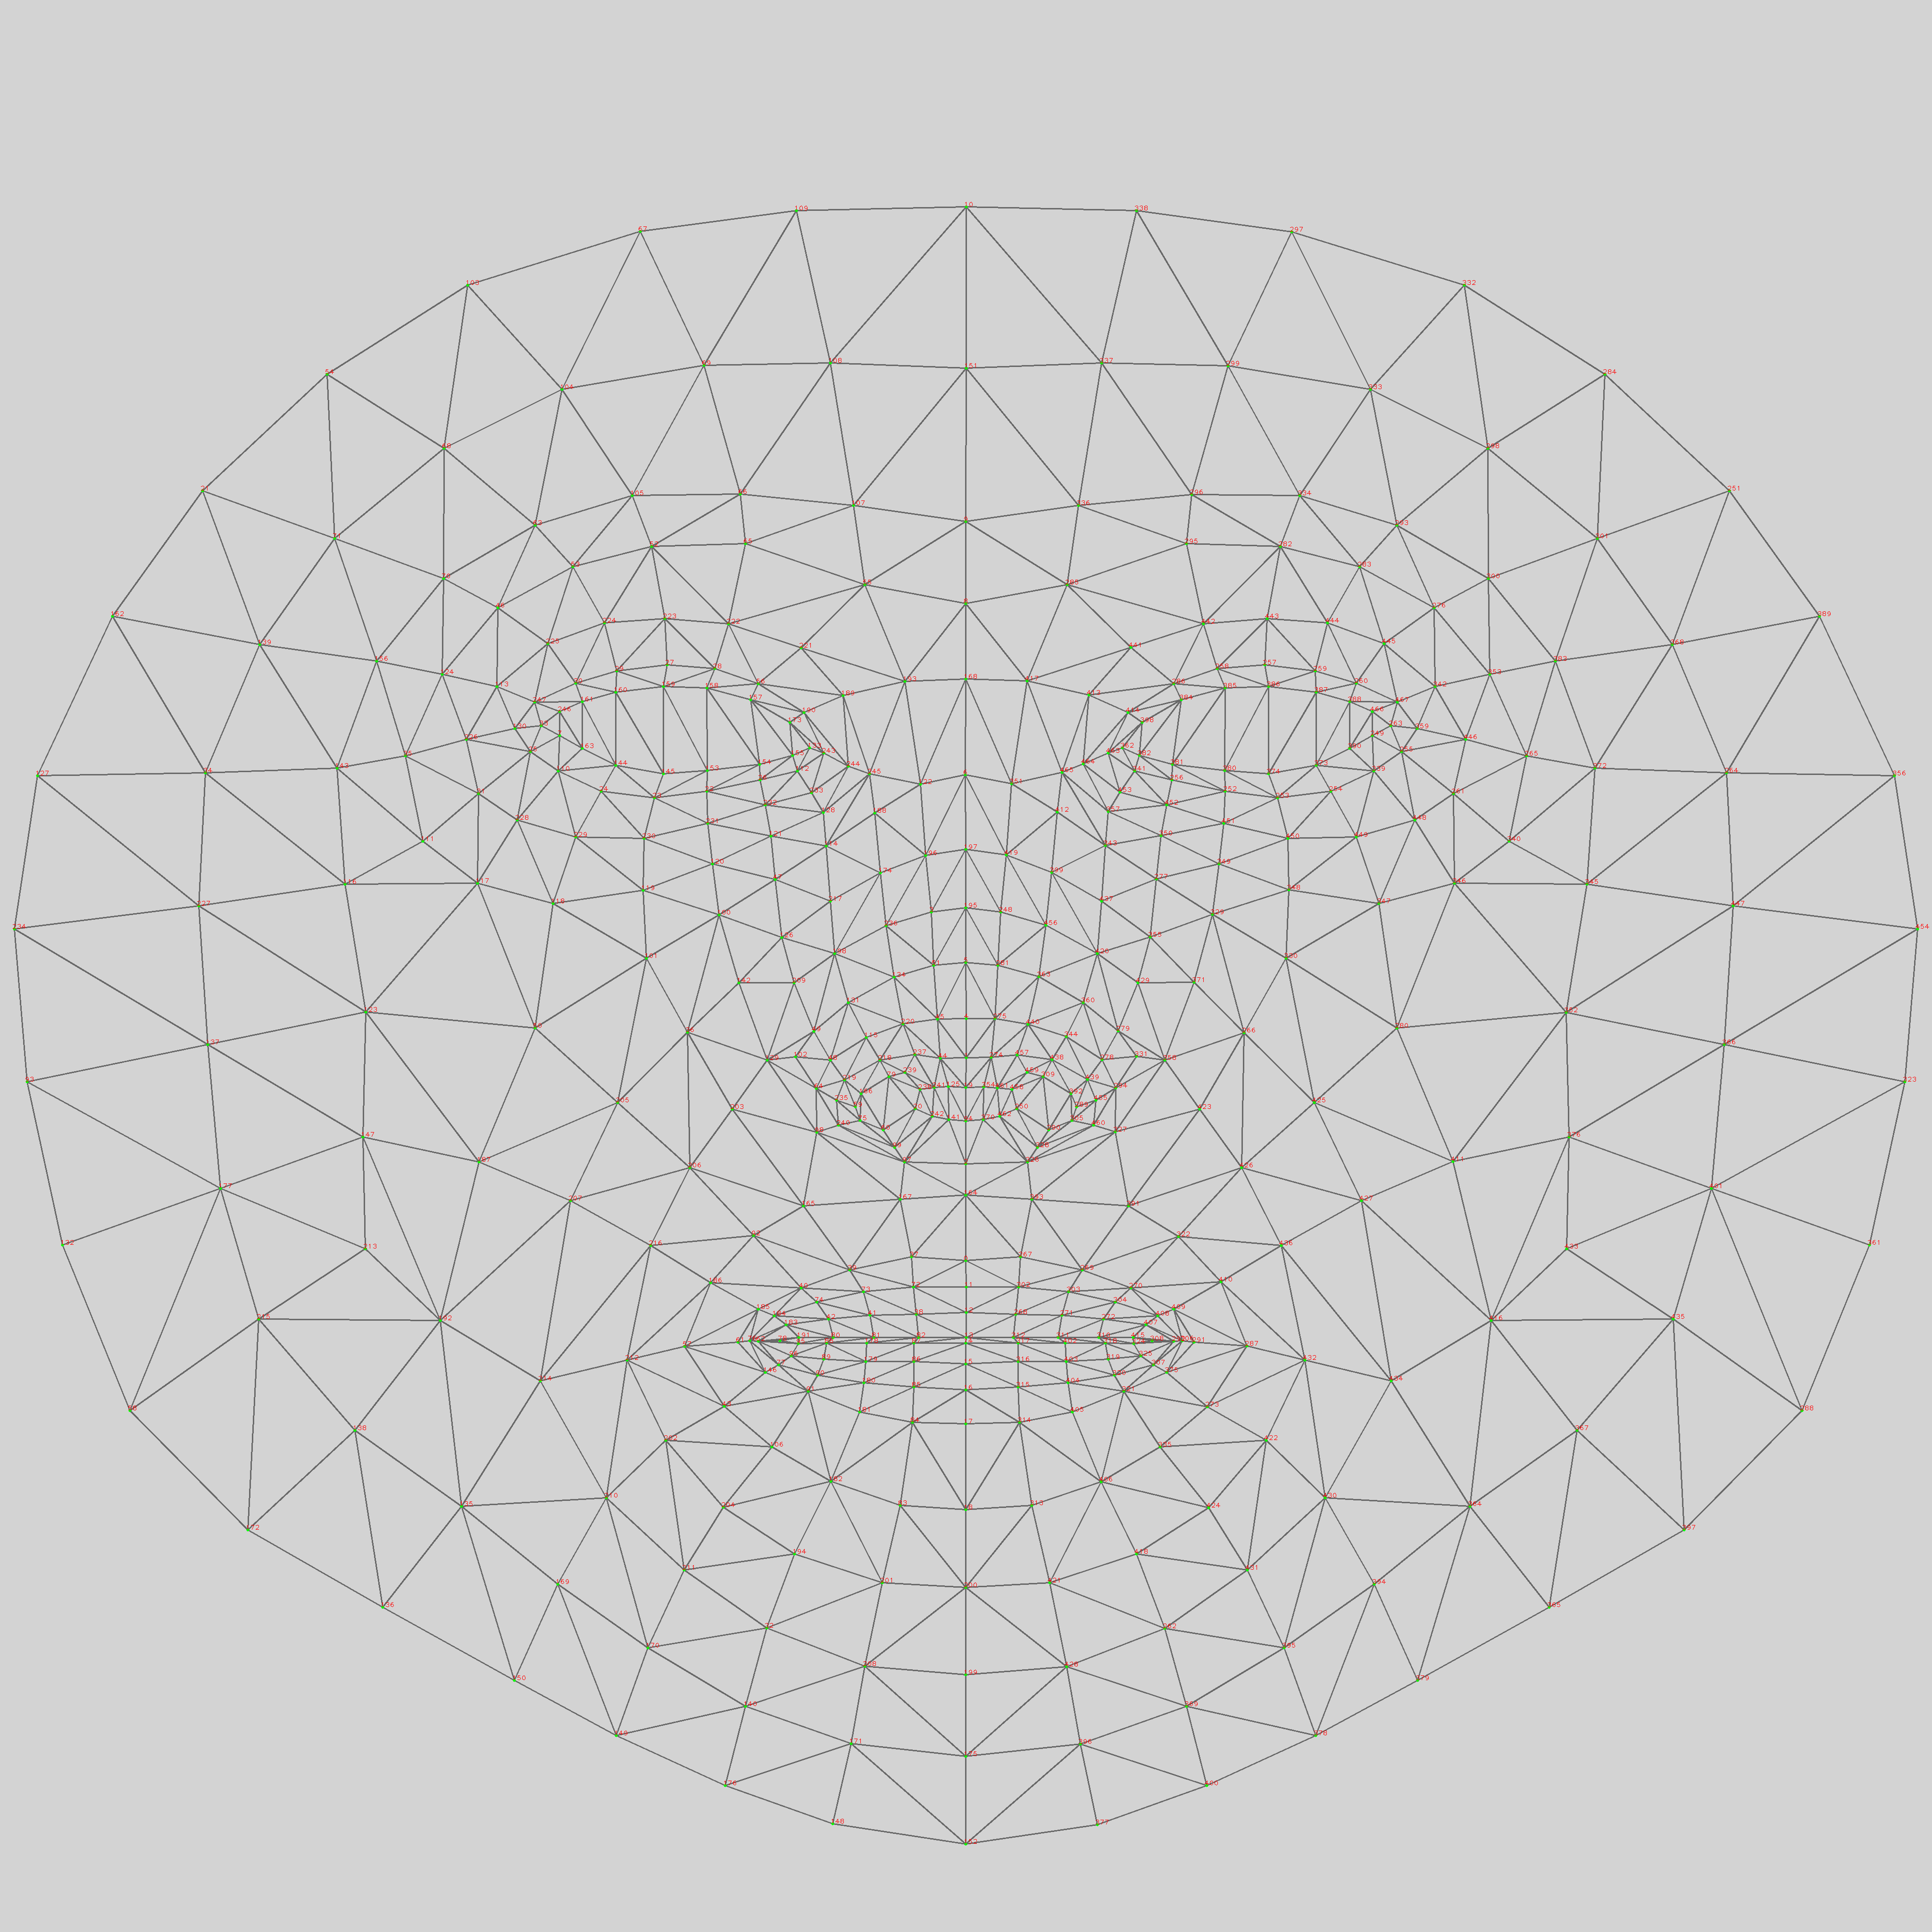

> **We Pick Nose Point To Normalize Data Across It** with index 1

### Normalize Data Around Nose

In [43]:
x_columns = [f for f in features.columns
             if "x_" in f]

y_columns = [f for f in features.columns
             if "y_" in f]

In [44]:
Nose_Points = features[['x_195', 'y_195']]

for col in features.columns:
  if col in x_columns:
    features[col] = features[col].sub(Nose_Points['x_195'])
  else:
    features[col] = features[col].sub(Nose_Points['y_195'])

In [45]:
features.head(5)

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467,x_468,y_468
0,0.467549,-0.326133,0.691667,-0.528071,0.506962,-0.470641,0.592279,-0.812192,0.720405,-0.609113,...,0.538269,-1.071092,0.535181,-1.043433,0.556855,-1.018180,0.700243,-1.084597,0.716563,-1.109849
1,0.049386,-0.374437,-0.144638,-0.702176,0.013237,-0.654824,-0.212409,-1.136720,-0.177054,-0.810201,...,0.368272,-1.660452,0.286965,-1.600746,0.222572,-1.546306,1.018031,-1.778899,1.090450,-1.872409
2,0.406182,-0.397784,0.601426,-0.634277,0.398185,-0.553361,0.461428,-0.889242,0.621696,-0.714192,...,0.320247,-1.181770,0.321809,-1.146905,0.352615,-1.119052,0.422675,-1.242520,0.426768,-1.276013
3,0.169500,-0.390650,0.091254,-0.722547,0.139138,-0.636101,-0.017314,-1.116746,0.071058,-0.835235,...,0.345190,-1.523392,0.286857,-1.482182,0.249876,-1.449802,0.840192,-1.677440,0.883638,-1.734146
4,-0.163171,-0.320991,-0.423750,-0.641085,-0.199085,-0.592690,-0.432559,-1.029561,-0.462512,-0.740839,...,0.054155,-1.493338,-0.005385,-1.438337,-0.063612,-1.388483,0.520325,-1.587708,0.583610,-1.657019


### To Control Image Size Picking 2 Points and get distance and divide whole data over them so we will use Nose Points and Middle of forehead

In [46]:
Forehead_points = features[['x_195', 'y_195']]
Nose_Points = features[['x_6', 'y_6']]

distance_x = (Forehead_points['x_195'].sub(Nose_Points['x_6']))
distance_y = (Forehead_points['y_195'].sub(Nose_Points['y_6']))

distance = np.sqrt(distance_x**2 + distance_y**2)

features.iloc[:, :] = features.iloc[:, :].div(distance, axis=0)

In [47]:
features.head(5)

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467,x_468,y_468
0,0.467549,-0.326133,0.691667,-0.528071,0.506962,-0.470641,0.592279,-0.812192,0.720405,-0.609113,...,0.538269,-1.071092,0.535181,-1.043433,0.556855,-1.018180,0.700243,-1.084597,0.716563,-1.109849
1,0.049386,-0.374437,-0.144638,-0.702176,0.013237,-0.654824,-0.212409,-1.136720,-0.177054,-0.810201,...,0.368272,-1.660452,0.286965,-1.600746,0.222572,-1.546306,1.018031,-1.778899,1.090450,-1.872409
2,0.406182,-0.397784,0.601426,-0.634277,0.398185,-0.553361,0.461428,-0.889242,0.621696,-0.714192,...,0.320247,-1.181770,0.321809,-1.146905,0.352615,-1.119052,0.422675,-1.242520,0.426768,-1.276013
3,0.169500,-0.390650,0.091254,-0.722547,0.139138,-0.636101,-0.017314,-1.116746,0.071058,-0.835235,...,0.345190,-1.523392,0.286857,-1.482182,0.249876,-1.449802,0.840192,-1.677440,0.883638,-1.734146
4,-0.163171,-0.320991,-0.423750,-0.641085,-0.199085,-0.592690,-0.432559,-1.029561,-0.462512,-0.740839,...,0.054155,-1.493338,-0.005385,-1.438337,-0.063612,-1.388483,0.520325,-1.587708,0.583610,-1.657019


In [48]:
def preprocess(features):
  x_columns = [f for f in features.columns if "x_" in f]
  y_columns = [f for f in features.columns if "y_" in f]
  Nose_Points = features[['x_195', 'y_195']]
  for col in features.columns:
    if col in x_columns:
      features[col] = features[col].sub(Nose_Points['x_195'])
    else:
      features[col] = features[col].sub(Nose_Points['y_195'])

  Forehead_points = features[['x_195', 'y_195']]
  Nose_Points = features[['x_6', 'y_6']]

  distance_x = (Forehead_points['x_195'].sub(Nose_Points['x_6']))
  distance_y = (Forehead_points['y_195'].sub(Nose_Points['y_6']))
  
  distance = np.sqrt(distance_x**2 + distance_y**2)
  features.iloc[:, :] = features.iloc[:, :].div(distance, axis=0)

  return features

## Split Data

In [49]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=256)

## Training Model

In [50]:
from sklearn.multioutput import MultiOutputRegressor

### SVM

In [51]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [52]:

grid_param_svr = {
    'estimator__C': [10, 20, 25, 30, 50],
    'estimator__kernel': ['rbf'],
    'estimator__epsilon': [0.1, 0.001, 0.01]
}
model_svr = MultiOutputRegressor(SVR())
gs_svr = GridSearchCV(estimator=model_svr, 
                      param_grid=grid_param_svr, 
                      cv=2,
                      n_jobs = -1)
gs_svr = gs_svr.fit(x_train,y_train)
print(gs_svr.score(x_train, y_train)*100, "%")
print(gs_svr.score(x_test, y_test)*100, "%")

45.81363084223496 %
84.98031250814479 %


In [53]:
print("Best Parameters: ", gs_svr.best_params_)
print("Best Score: ", gs_svr.best_score_)

Best Parameters:  {'estimator__C': 30, 'estimator__epsilon': 0.01, 'estimator__kernel': 'rbf'}
Best Score:  0.5602722359168445


### Gradient Boost Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=.01, max_depth=2, random_state=256))
model.fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

71.29255244338349 %
40.54729835973485 %


### Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
regr = MultiOutputRegressor(RandomForestRegressor(max_depth=20, random_state=256, bootstrap=True), n_jobs=-1)
regr.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=20,
                                                     random_state=256),
                     n_jobs=-1)

In [65]:
print(regr.score(x_train, y_train)*100, "%")
print(regr.score(x_test, y_test)*100, "%")

87.15072187242848 %
80.06606725613624 %


### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
model = MultiOutputRegressor(ElasticNet(alpha=0.005,max_iter=1000,tol=10e-6)).fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

### ADABoost 

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
model = MultiOutputRegressor(AdaBoostRegressor(random_state=256, n_estimators=300)).fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

85.5352027819316 %
43.99524285281447 %


### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = MultiOutputRegressor(LinearRegression()).fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
model = MultiOutputRegressor(DecisionTreeRegressor(random_state=42)).fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

100.0 %
-277.5863346986538 %


### LGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
model = MultiOutputRegressor(LGBMRegressor(random_state=256)).fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

80.79698461710527 %
46.069898893888634 %


### XGBoost

In [ ]:
from xgboost.sklearn import XGBRegressor

In [ ]:
model = MultiOutputRegressor(XGBRegressor(random_state=256, max_depth=5, n_estimators=300), n_jobs=-1).fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

99.97559981989093 %
83.75880271523745 %


### BayesianRidge

In [ ]:
from sklearn.linear_model import BayesianRidge

In [ ]:
model = MultiOutputRegressor(BayesianRidge()).fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

92.15674278999094 %
18.707679190199507 %


### Kernel Ridge

In [ ]:
from sklearn.kernel_ridge import KernelRidge

In [ ]:
model = MultiOutputRegressor(KernelRidge()).fit(x_train, y_train)
print(model.score(x_train, y_train)*100, "%")
print(model.score(x_test, y_test)*100, "%")

51.103415599303126 %
34.63245237417542 %


## Test New Data

### SVM

In [73]:
image = cv2.imread("/content/test3.jpg")
data_img = extract_data(image)
data_img = pd.DataFrame(data_img)
res1 = gs_svr.predict(data_img)

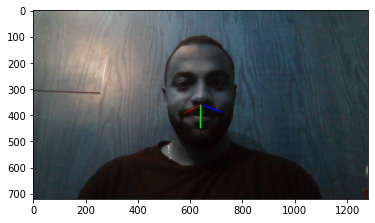

In [76]:
plt.imshow(draw_axis(image, res1[0][0],res1[0][1],res1[0][2]))
plt.show()

### Random Forest

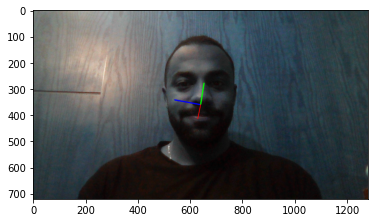

In [ ]:
image = cv2.imread("/content/test3.jpg")
data_img = extract_data(image)
data_img = pd.DataFrame(data_img)
res2 = regr.predict(data_img)
plt.imshow(draw_axis(image, res2[0][0],res2[0][1],res2[0][2]))

### XGBoost

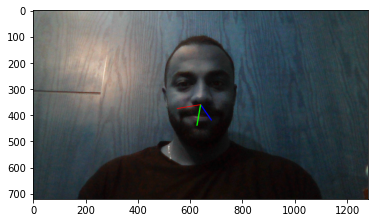

In [ ]:
image = cv2.imread("/content/test3.jpg")
data_img = extract_data(image)
data_img = pd.DataFrame(data_img)
res2 = model.predict(data_img)
plt.imshow(draw_axis(image, res2[0][0],res2[0][1],res2[0][2]))

In [ ]:
img_dt = pd.DataFrame(extract_data(image))

In [ ]:
def draw_points(imagename, path):

  print(path+imagename+'.jpg')
  faceModule = mp.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      image = cv2.imread(path+imagename+'.jpg')
      
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])

                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        cv2_imshow(image)

/content/test3.jpg


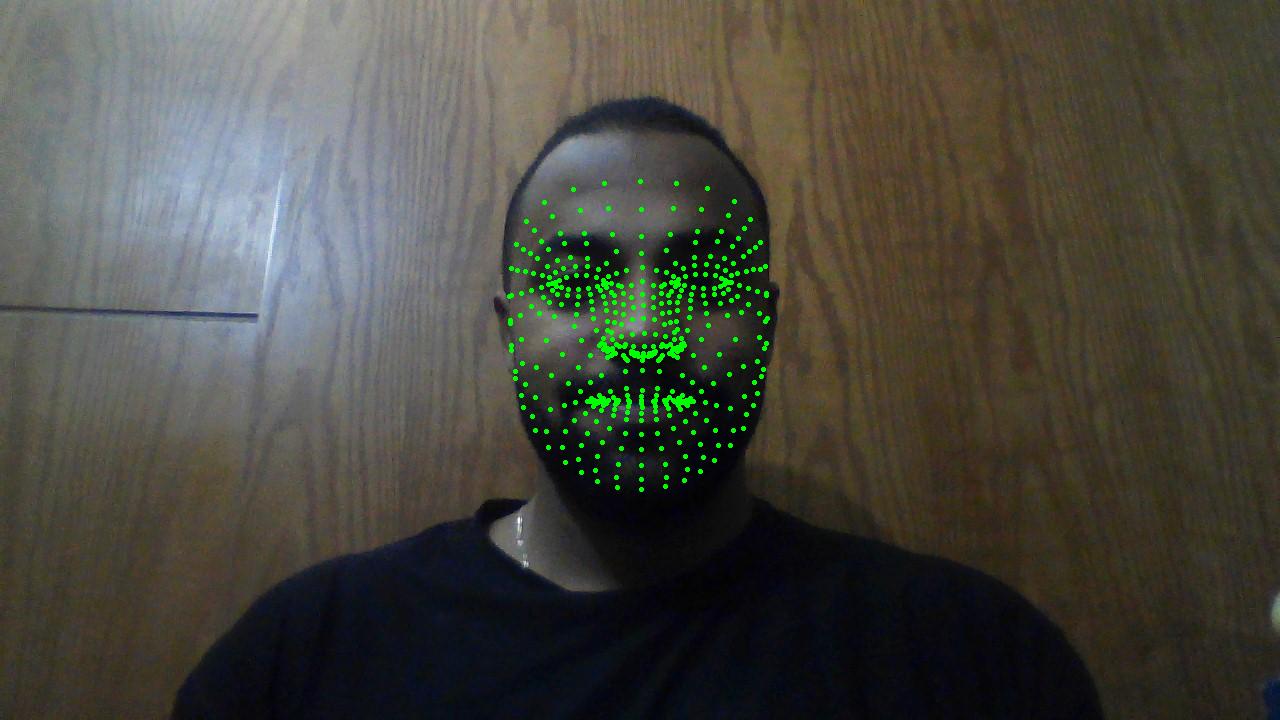

In [ ]:
draw_points('test3', '/content/')

## Video Test

In [70]:
video = '/content/test_vid.mp4'

cap = cv2.VideoCapture(video)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)

810


In [ ]:
ex = cv2.VideoWriter_fourcc(*'mp4v') 
video_output = cv2.VideoWriter("output_SVM.mp4", ex, 20, (width,height))
i = 0
while(cap.isOpened()):

  if i < 310:
    r, f = cap.read()

    if r is not True: 
      break

    v_test = pd.DataFrame(extract_data(f))
    v_test_new = preprocess(v_test)

    res = gs_svr.predict(v_test_new)
    result = draw_axis(f, res[0][0], res[0][1], res[0][2])
    
    video_output.write(result)
    i+=1
  else:
    break

print(i, "frames")
cv2.destroyAllWindows()
video_output.release()

In [ ]:
ex = cv2.VideoWriter_fourcc(*'mp4v') 
video_output = cv2.VideoWriter("output_RF.mp4", ex, 20, (width,height))
i = 0
while(cap.isOpened()):

  if i < 310:
    r, f = cap.read()

    if r is not True: 
      break

    v_test = pd.DataFrame(extract_data(f))
    v_test_new = preprocess(v_test)

    res = regr.predict(v_test_new)
    result = draw_axis(f, res[0][0], res[0][1], res[0][2])
    
    video_output.write(result)
    i+=1
  else:
    break

print(i, "frames")
cv2.destroyAllWindows()
video_output.release()